# ML for climate and Energy (MEC51057)
# Group project: Weather station

**Mentor**:
- Julio 

**Students**:
- Dimitri Iratchet
- Fabien Lagnieu
- Tristan Waddington

## 1. Data loading

In [110]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime


The variables in this data set are the raw variables that you can find in the ERA reanalysis

| Variable name  | Description                             | Unit    |
| :------------- | :-------------                          | :------ |
| t2m            | Air temperature at 2 m above the ground | [K]     |
| d2m            | [Dew point](https://en.wikipedia.org/wiki/Dew_point) at 2 m above the ground       | [K]     |
| u10            | Zonal wind component at 10 m            | [m/s]   |
| v10            | Meridional wind component at 10 m       | [m/s]   |
| skt            | Skin temperature                        | [K]     |
| tcc            | Total cloud cover                       | [0-1]   |
| sp             | Surface pressure                        | [Pa]    |
| tp             | Total precipitation                     | [m]     |
| ssrd           | Surface solar radiation (downwards)     | [J/m^2] |
| blh            | Boundary layer height                   | [m]     |


### 1.1 File control

In [133]:
base_path: Path = Path("data", "weather_data")

In [136]:
# Control the content of the datafiles
for subfolder in base_path.iterdir():
    # subfolder_path = os.path.join(base_path, subfolder)
    if not subfolder.is_dir():
        continue
    print(f"========== {subfolder.name.capitalize()} weather station data ===========")
    print("File Name\tStart date       ->End date\t\tstep\tnb values")
    for file_name in subfolder.iterdir():
        if file_name.suffix != ".nc":
            continue
        ds = xr.open_dataset(file_name)
        # display a global summary
        first_timstep = ds.time[0].dt.strftime("%Y %b %d %H:%M").item()
        last_timstep = ds.time[-1].dt.strftime("%Y %b %d %H:%M").item()
        timestep = (ds.time[1] - ds.time[0]).dt.seconds.item() / 3600
        total_values = ds.sizes["time"]

        print(
            f"File {file_name},\t{first_timstep}->{last_timstep}\t"
            f"{timestep}h\t{total_values}"
        )

========== Paris weather station data ===========
File Name	Start date       ->End date		step	nb values
File data/weather_data/paris/blh.nc,	1980 Jan 01 07:00->2021 Jan 01 06:00	1.0h	359424
File data/weather_data/paris/t2m.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/tcc.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/u10.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/skt.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/d2m.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/v10.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/tp.nc,	1980 Jan 01 07:00->2021 Jan 01 06:00	1.0h	359424
File data/weather_data/paris/ssrd.nc,	1980 Jan 01 07:00->2021 Jan 01 06:00	1.0h	359424
File data/weather_data/paris/sp.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
========== Marseille weather station 

### 1.2 Load into Pandas DataFrame

In [ ]:
# Load the data by City
def load_nc_files_by_subfolders(base_path: Path) -> pd.DataFrame:
    """Load weather data as a dict of DataFrame by city containing all variables."""
    dataframes: dict[pd.DataFrame] = {}
    for subfolder in base_path.iterdir():
        # subfolder_path = os.path.join(base_path, subfolder)
        if not subfolder.is_dir():
            continue
        combined_ds = None
        for file in subfolder.iterdir():
            if file.suffix != ".nc":
                continue
            # file_path = os.path.join(subfolder_path, file)
            ds = xr.load_dataset(file)
            # ds = ds.rename({var: f"{file.split('.')[0]}_{var}" for var in ds.data_vars})
            if combined_ds is None:
                combined_ds = ds
            else:
                combined_ds = xr.concat([combined_ds, ds], dim="time")
        if combined_ds is not None:
            dataframes[subfolder.name] = combined_ds.to_dataframe()
    return dataframes


weather_stations: dict[pd.DataFrame] = load_nc_files_by_subfolders(base_path)

In [ ]:
# Load the data by City
def load_nc_files_by_subfolders(base_path: Path) -> dict[str, pd.DataFrame]:
    """Load weather data as a dict of DataFrame by city containing all variables."""
    dataframes: dict[str, pd.DataFrame] = {}
    for subfolder in base_path.iterdir():
        if not subfolder.is_dir():
            continue
        nc_files = list(subfolder.glob("*.nc"))
        if not nc_files:
            continue
        combined_ds = xr.open_mfdataset(nc_files, combine="by_coords")
        combined_ds = combined_ds.dropna(
            dim="time", how="all"
        )  # Drop NaN values along the time dimension
        dataframes[subfolder.name] = (
            combined_ds.to_dataframe().dropna()
        )  # Drop remaining NaN values
    return dataframes


weather_stations = load_nc_files_by_subfolders(base_path)

In [155]:
cities: list[str] = list(weather_stations.keys())
print(cities)

['paris', 'marseille', 'brest', 'london', 'berlin']


In [162]:
weather_stations["paris"].describe()

,blh,d2m,skt,sp,ssrd,t2m,tcc,tp,u10,v10
count,359417.000000,359417.000000,359417.000000,359417.000000,3.594170e+05,359417.000000,359417.000000,359417.000000,359417.000000,359417.000000
mean,604.317078,280.462860,284.343781,100415.406250,4.776419e+05,284.404419,0.664972,0.000082,0.864810,0.351663
std,470.653076,5.681643,7.730831,906.632751,7.350288e+05,7.121730,0.369240,0.000297,2.641548,2.879296
min,9.829140,254.678604,252.089996,94526.585938,-1.901566e+00,256.771332,0.000000,0.000000,-9.424118,-10.220169
25%,205.057785,276.560394,278.848663,99890.265625,0.000000e+00,279.367126,0.347229,0.000000,-1.184723,-1.833115
50%,492.641144,280.908813,283.880432,100472.210938,2.099200e+04,284.210480,0.842041,0.000000,0.842026,0.232529
75%,915.958130,284.717346,289.336578,101001.015625,7.504640e+05,289.264130,0.998413,0.000009,2.671127,2.403152
max,3572.631348,295.901764,317.110504,103395.062500,3.315712e+06,314.154785,1.000000,0.011550,16.235458,14.881912


> The data is not normalized. This could be an issue during the training.


In [164]:
weather_stations["paris"].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 359417 entries, (48.75, 2.25, Timestamp('1980-01-01 07:00:00')) to (48.75, 2.25, Timestamp('2020-12-31 23:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   blh     359417 non-null  float32
 1   d2m     359417 non-null  float32
 2   skt     359417 non-null  float32
 3   sp      359417 non-null  float32
 4   ssrd    359417 non-null  float32
 5   t2m     359417 non-null  float32
 6   tcc     359417 non-null  float32
 7   tp      359417 non-null  float32
 8   u10     359417 non-null  float32
 9   v10     359417 non-null  float32
dtypes: float32(10)
memory usage: 26.6 MB


> The DataFrame is loaded with a multi-index. We will delete it to access to the descriptioon of the data.

#### Extract the city coordinates for later use

In [167]:
weather_stations["paris"].index[0][1:]

cities_latlon: dict[tuple[float]] = {
    city: weather_stations[city].index[0][:2] for city in cities
}
print(cities_latlon)

{'paris': (48.75, 2.25), 'marseille': (43.25, 5.5), 'brest': (48.5, 355.5), 'london': (51.5, 359.75), 'berlin': (52.5, 13.5)}


### Plot on a map
with `cartopy` https://scitools.org.uk/cartopy/docs/latest/gallery/lines_and_polygons/features.html#sphx-glr-gallery-lines-and-polygons-features-py

This will download the background on first use.

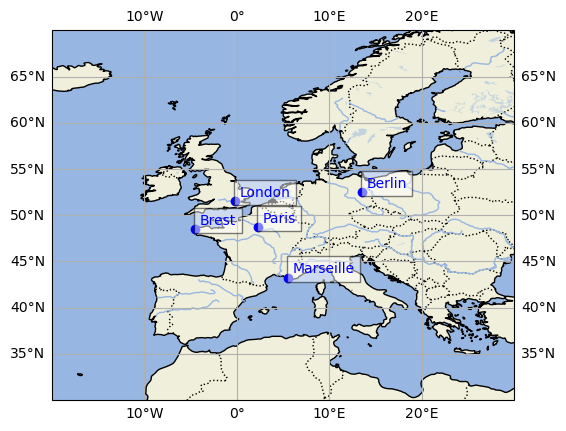

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-20, 30, 30, 70], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True)
for city, (lat, lon) in cities_latlon.items():
    ax.text(
        lon + 0.5,
        lat + 0.5,
        city.capitalize(),
        bbox=dict(facecolor="white", alpha=0.5),
        color="b",
        transform=ccrs.PlateCarree(),
    )
    ax.plot(lon, lat, "bo", transform=ccrs.PlateCarree())
ax.plot()
plt.show()

#### Data cleaning

In [ ]:
for city in weather_stations.keys():
    # Delete the multiindex
    weather_stations[city].reset_index(
        level=["latitude", "longitude"], drop=True, inplace=True
    )

In [173]:
# Get the minimum and maximum time for each dataset
min_times = [df.index.min() for df in weather_stations.values()]
max_times = [df.index.max() for df in weather_stations.values()]

# Determine the common timeframe
common_min_time = max(min_times)
common_max_time = min(max_times)
print(f"Common timeframe: {common_min_time} to {common_max_time}")

# Filter each dataset to keep only the common timeframe
for city in weather_stations:
    weather_stations[city] = weather_stations[city].loc[common_min_time:common_max_time]


Common timeframe: 1980-01-01 07:00:00 to 2019-12-31 23:00:00


### 1.3 Split the datasets

In [188]:
split_date = "01-01-2016"

In [ ]:
# Create a dictionary to hold the datasets for each variable
variable_datasets_X = {}
variable_datasets_y = {}

# Get the list of variables from one of the city's dataset
variables = weather_stations[cities[0]].columns

# Iterate over each variable
for variable in variables:
    # Create a DataFrame for the current variable
    variable_df_X = pd.DataFrame()
    variable_df_y = pd.DataFrame()

    # Iterate over each city and add the variable data to the DataFrame
    for city in cities:
        if city == "paris":
            variable_df_y[city] = weather_stations[city][variable]
        else:
            variable_df_X[city] = weather_stations[city][variable]

    # Add the DataFrame to the dictionary
    variable_datasets_X[variable] = variable_df_X
    variable_datasets_y[variable] = variable_df_y

# Print the keys of the dictionary to verify
print(variable_datasets_X.keys())

dict_keys(['blh', 'd2m', 'skt', 'sp', 'ssrd', 't2m', 'tcc', 'tp', 'u10', 'v10'])


In [183]:
variable_datasets_X["blh"]

,marseille,brest,london,berlin
time,,,,
1980-01-01 07:00:00,387.289490,278.789490,116.914497,502.789490
1980-01-01 08:00:00,382.825958,263.075958,126.200958,487.700958
1980-01-01 09:00:00,419.158630,258.783630,144.283615,511.283630
1980-01-01 10:00:00,528.698120,316.948090,187.573105,498.823090
1980-01-01 11:00:00,644.350281,348.975311,242.350311,476.975311
...,...,...,...,...
2019-12-31 19:00:00,288.035522,272.035522,487.660522,598.160522
2019-12-31 20:00:00,299.279602,237.779587,492.029602,502.529602
2019-12-31 21:00:00,284.007660,213.132645,475.382660,455.757660


In [ ]:
# Convert split_date to a pandas datetime object
split_date = pd.to_datetime(split_date, format="%d-%m-%Y")

# Create dictionaries to hold the train and test datasets for each variable
variable_datasets_X_train = {}
variable_datasets_X_test = {}
variable_datasets_y_train = {}
variable_datasets_y_test = {}

# Split the datasets
for variable in variables:
    # Split the X dataset
    variable_datasets_X_train[variable] = variable_datasets_X[variable][
        variable_datasets_X[variable].index < split_date
    ]
    variable_datasets_X_test[variable] = variable_datasets_X[variable][
        variable_datasets_X[variable].index >= split_date
    ]

    # Split the y dataset
    variable_datasets_y_train[variable] = variable_datasets_y[variable][
        variable_datasets_y[variable].index < split_date
    ]
    variable_datasets_y_test[variable] = variable_datasets_y[variable][
        variable_datasets_y[variable].index >= split_date
    ]

# Print the shapes of the train and test datasets to verify
for variable in variables:
    print(
        f"{variable} - Train X: {variable_datasets_X_train[variable].shape}, Test X: {variable_datasets_X_test[variable].shape}"
    )
    print(
        f"{variable} - Train y: {variable_datasets_y_train[variable].shape}, Test y: {variable_datasets_y_test[variable].shape}"
    )

blh - Train X: (315569, 4), Test X: (35064, 4)
blh - Train y: (315569, 1), Test y: (35064, 1)
d2m - Train X: (315569, 4), Test X: (35064, 4)
d2m - Train y: (315569, 1), Test y: (35064, 1)
skt - Train X: (315569, 4), Test X: (35064, 4)
skt - Train y: (315569, 1), Test y: (35064, 1)
sp - Train X: (315569, 4), Test X: (35064, 4)
sp - Train y: (315569, 1), Test y: (35064, 1)
ssrd - Train X: (315569, 4), Test X: (35064, 4)
ssrd - Train y: (315569, 1), Test y: (35064, 1)
t2m - Train X: (315569, 4), Test X: (35064, 4)
t2m - Train y: (315569, 1), Test y: (35064, 1)
tcc - Train X: (315569, 4), Test X: (35064, 4)
tcc - Train y: (315569, 1), Test y: (35064, 1)
tp - Train X: (315569, 4), Test X: (35064, 4)
tp - Train y: (315569, 1), Test y: (35064, 1)
u10 - Train X: (315569, 4), Test X: (35064, 4)
u10 - Train y: (315569, 1), Test y: (35064, 1)
v10 - Train X: (315569, 4), Test X: (35064, 4)
v10 - Train y: (315569, 1), Test y: (35064, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize each dataset
scalers_X = {}
scalers_y = {}

for variable in variables:
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Normalize the train X dataset
    variable_datasets_X_train[variable] = pd.DataFrame(
        scaler_X.fit_transform(variable_datasets_X_train[variable]),
        index=variable_datasets_X_train[variable].index,
        columns=variable_datasets_X_train[variable].columns,
    )

    # Normalize the test X dataset using the same scaler
    variable_datasets_X_test[variable] = pd.DataFrame(
        scaler_X.transform(variable_datasets_X_test[variable]),
        index=variable_datasets_X_test[variable].index,
        columns=variable_datasets_X_test[variable].columns,
    )

    # Normalize the train y dataset
    variable_datasets_y_train[variable] = pd.DataFrame(
        scaler_y.fit_transform(variable_datasets_y_train[variable]),
        index=variable_datasets_y_train[variable].index,
        columns=variable_datasets_y_train[variable].columns,
    )

    # Normalize the test y dataset using the same scaler
    variable_datasets_y_test[variable] = pd.DataFrame(
        scaler_y.transform(variable_datasets_y_test[variable]),
        index=variable_datasets_y_test[variable].index,
        columns=variable_datasets_y_test[variable].columns,
    )

    scalers_X[variable] = scaler_X
    scalers_y[variable] = scaler_y

In [198]:
variable_datasets_y_train["skt"].describe()

,paris
count,3.155690e+05
mean,-1.199161e-08
std,9.999596e-01
min,-4.190093e+00
25%,-7.098190e-01
50%,-5.086244e-02
75%,6.487415e-01
max,4.024086e+00


In [ ]:
# Save variable_datasets_X_train to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_X_train.h5") as store:
    for variable, df in variable_datasets_X_train.items():
        store.put(variable, df)

# Save variable_datasets_X_test to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_X_test.h5") as store:
    for variable, df in variable_datasets_X_test.items():
        store.put(variable, df)

# Save variable_datasets_y_train to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_y_train.h5") as store:
    for variable, df in variable_datasets_y_train.items():
        store.put(variable, df)

# Save variable_datasets_y_test to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_y_test.h5") as store:
    for variable, df in variable_datasets_y_test.items():
        store.put(variable, df)

In [ ]:
def load_normalize_data():
    """Load the previous prepared normalized dataset
    returns: X_train, X_test, y_train, Y_test"""
    # Load variable_datasets_X_train from HDF5
    variable_datasets_X_train = {}
    with pd.HDFStore("data/norm_data/variable_datasets_X_train.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_X_train[variable_name] = store[variable]

    # Load variable_datasets_X_test from HDF5
    variable_datasets_X_test = {}
    with pd.HDFStore("data/norm_data/variable_datasets_X_test.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_X_test[variable_name] = store[variable]

    # Load variable_datasets_y_train from HDF5
    variable_datasets_y_train = {}
    with pd.HDFStore("data/norm_data/variable_datasets_y_train.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_y_train[variable_name] = store[variable]

    # Load variable_datasets_y_test from HDF5
    variable_datasets_y_test = {}
    with pd.HDFStore("data/norm_data/variable_datasets_y_test.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_y_test[variable_name] = store[variable]

    return (
        variable_datasets_X_train,
        variable_datasets_X_test,
        variable_datasets_y_train,
        variable_datasets_y_test,
    )

## 2. Dig into the data

In [203]:
X_train, X_test, y_train, y_test = load_normalize_data()

### 2.1 Cycles

### 2.2 Covariances and related variable by city

In [ ]:
city = "berlin"
berlin_df = weather_stations[city]

berlin_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3506400 entries, (Timestamp('1980-01-01 07:00:00'), 52.5, 13.5) to (Timestamp('2019-12-31 23:00:00'), 52.5, 13.5)
Data columns (total 10 columns):
 #   Column  Dtype  
---  ------  -----  
 0   blh     float32
 1   t2m     float32
 2   tcc     float32
 3   u10     float32
 4   skt     float32
 5   d2m     float32
 6   v10     float32
 7   tp      float32
 8   ssrd    float32
 9   sp      float32
dtypes: float32(10)
memory usage: 164.6 MB


In [ ]:
berlin_df.index = berlin_df.index.droplevel(["latitude", "longitude"])
berlin_df

,blh,t2m,tcc,u10,skt,d2m,v10,tp,ssrd,sp
time,,,,,,,,,,
1980-01-01 07:00:00,502.789490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01 08:00:00,487.700958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01 09:00:00,511.283630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01 10:00:00,498.823090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01 11:00:00,476.975311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102599.195312
2019-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102615.515625
2019-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102653.062500


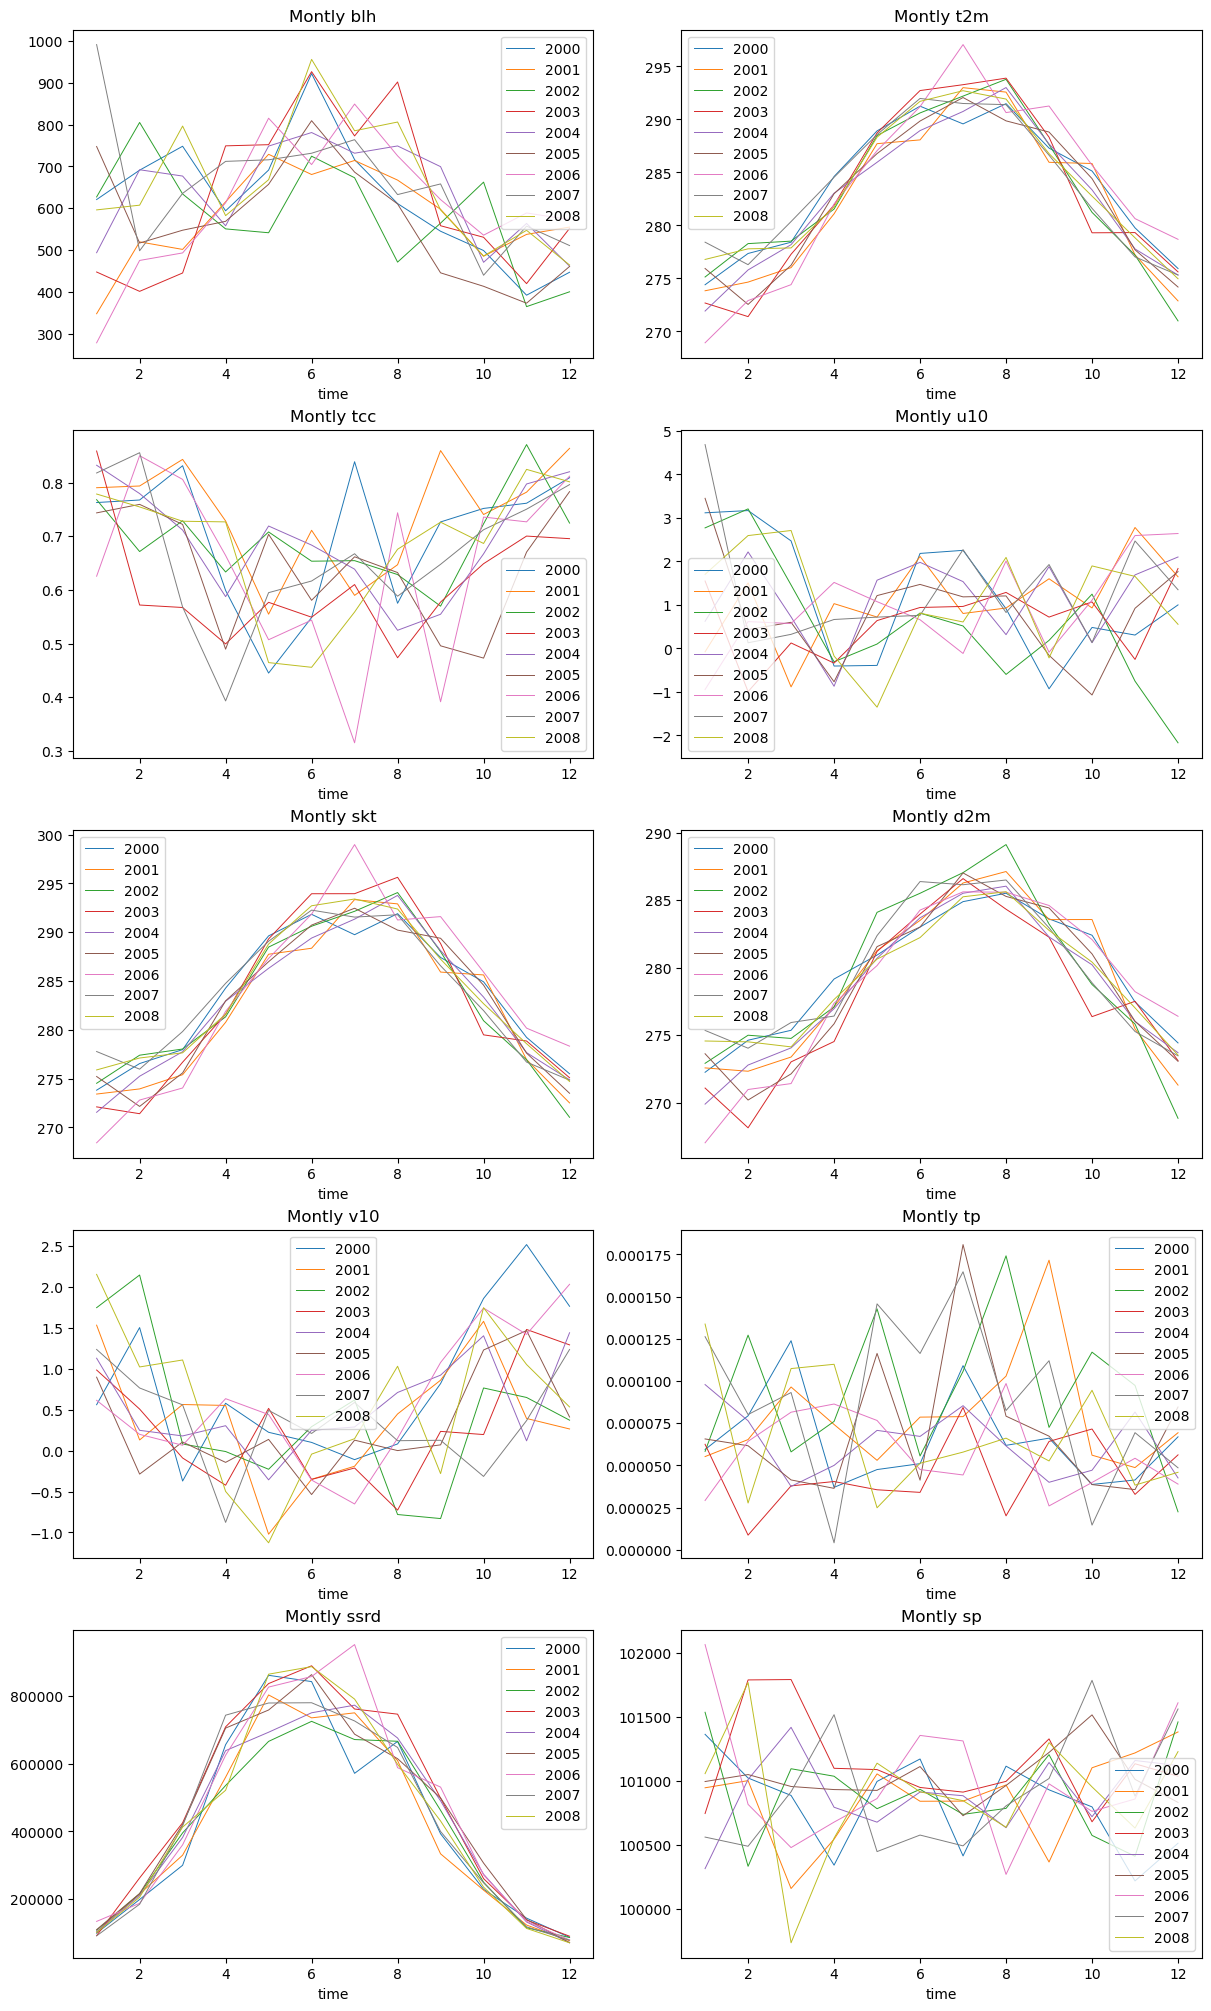

In [ ]:
df = berlin_df
fig, axes = plt.subplots(5, 2, figsize=(12, 20), layout="constrained")
axes = axes.flatten()
for year in range(2000, 2008 + 1):
    df_year = df[df.index.year == year]
    for name, ax in zip(df.columns, axes):
        df_year.groupby(by=df_year.index.month).mean()[name].plot(
            ax=ax, label=year, linewidth=0.7
        )
        ax.set_title(f"Montly {name}")
        ax.legend()
plt.show()

### 2.3 Covariance between cities

## 3. Machine learning
Split the data :
- train = 1980-2015 (included)
- test = 2016-2019 (included)

In [ ]:
split_date = "01-01-2016"

Normalize data based on train dataset values.

### 3.1 Model1:

### 3.2 Model2:

### 3.3 Model3:

## 4. Bonus: confidence interval 

Clean notebook at the end, final process, 

Reprodcutibility cross validation with seeds,L

Loaded with githubs